---
<h1 style="text-align: center;">
Data Cleaning, Normalization, and Feature Selection Using PySpark
</h1>

<h1 style="text-align: center;">
Task 2
</h1>

<h3 style="text-align: center;">
Oct-03-2024
</h3>

---

### In the dataset `breast_cancer_dataset_2.csv`:
###  Each row is a sample and column is a feature (or label). 
### Each sample has a patient ID (first column) and diagnosis/label (second column) with values "M" for malignant and "B" for benign.

In [1]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

#### 0. Load the dataset and print the top 10 rows and the number of samples and features. Note, this dataset includes a header (the first line in the csv file).

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.types import NumericType
import pyspark.sql.functions as F

spark = SparkSession.builder.getOrCreate()

df = spark.read.csv("data/breast_cancer_dataset_2.csv", header = True)

df.show(10)
num_samples = df.count()
num_features = len(df.columns)
print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features-1}")  # removing diagnosis/label

+----------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|patient_id|diagnosis|mean_radius|mean_texture|mean_perimeter|mean_area|mean_smoothness|mean_compactness|mean_concavity|mean_concave_points|mean_symmetry|mean_fractal_dimension|se_radius|se_texture|se_perimeter|se_area|se_smoothness|se_compactness|se_concavity|se_concave_points|se_symmetry|se_fractal_dimension|worst_radius|worst_texture|worst_perimeter|worst_area|worst_smoothness|worst_compactness|worst_concavity|worst_concave_points|worst_symmetry|worst_fractal_dimension|
+----------+---------+-----------+----------

#### 1. What are the means, standard deviations, minimum, and maximum values of each of the features?

In [5]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

# change datatype of string dataset to double for assembler
for column in df.columns[2:]:  
    df = df.withColumn(column, col(column).cast(DoubleType()))
    
analysis_cols = [col for col, dtype in df.dtypes if dtype in ('double') and col != 'diagnosis']

stats = df.select(analysis_cols).describe()
stats.filter(stats["summary"] != "count").show()

+-------+------------------+------------------+-----------------+------------------+--------------------+--------------------+-------------------+--------------------+-------------------+----------------------+-------------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+--------------------+-------------------+-------------------+--------------------+-------------------+-----------------------+
|summary|       mean_radius|      mean_texture|   mean_perimeter|         mean_area|     mean_smoothness|    mean_compactness|     mean_concavity| mean_concave_points|      mean_symmetry|mean_fractal_dimension|          se_radius|        se_texture|      se_perimeter|           se_area|       se_smoothness|      se_compactness|        se_concavity|   se_concave_points|         se_sy

#### 2. Choose any method to replace all missing values and print the top 10 rows of the dataframe before and after the replacement. Explain what method you used and why.

In [6]:
numeric_cols = df.columns[2:]

print("Before Missing Values Replacement:")
df.show(10)  

for col_name in numeric_cols:
    # calculates medians of columns
    col_medians = df.agg(F.median(F.col(col_name)).alias('median')).collect()[0][0]
    df = df.fillna({col_name: col_medians})

print("After Missing Values Replacement:")
df.show(10)  

Before Missing Values Replacement:
+----------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|patient_id|diagnosis|mean_radius|mean_texture|mean_perimeter|mean_area|mean_smoothness|mean_compactness|mean_concavity|mean_concave_points|mean_symmetry|mean_fractal_dimension|se_radius|se_texture|se_perimeter|se_area|se_smoothness|se_compactness|se_concavity|se_concave_points|se_symmetry|se_fractal_dimension|worst_radius|worst_texture|worst_perimeter|worst_area|worst_smoothness|worst_compactness|worst_concavity|worst_concave_points|worst_symmetry|worst_fractal_dimension|
+--------

I used Median Feature Value method to fill in missing values in the numeric columns of the data. I think this method efficiently fills the missing values with the median for that specific column value.

#### 3. Choose any method to normalize or standardize the features and print the top 10 rows before and after. Explain what method you used and why. After the transformation, plot a histogram of values for feature "mean_symmetry".

In [7]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import expr
from pyspark.ml.functions import vector_to_array
import matplotlib.pyplot as plt

print("Before normalization:")
df.show(10)

assembler = VectorAssembler(inputCols=df.columns[2:], outputCol="features")
df_vector = assembler.transform(df)

scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df_vector)
df = scaler_model.transform(df_vector)

# converts scaled_feeatures header to array and names it scaled_features_array
df_with_array = df.withColumn("scaled_features_array", vector_to_array(col("scaled_features")))

# iterates through array to change each column
for i, col_name in enumerate(numeric_cols):
    df_with_array = df_with_array.withColumn(col_name, col("scaled_features_array")[i])

df = df_with_array.select("patient_id", "diagnosis", *numeric_cols)

print("After normalization:")
df.show(10, truncate=False)

Before normalization:
+----------+---------+-----------+------------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|patient_id|diagnosis|mean_radius|      mean_texture|mean_perimeter|mean_area|mean_smoothness|mean_compactness|mean_concavity|mean_concave_points|mean_symmetry|mean_fractal_dimension|se_radius|se_texture|      se_perimeter|se_area|se_smoothness|se_compactness|se_concavity|se_concave_points|se_symmetry|se_fractal_dimension|worst_radius|worst_texture|worst_perimeter|worst_area|worst_smoothness|worst_compactness|worst_concavity|worst_concave_points|worst_symmetry|worst_fractal_dimension

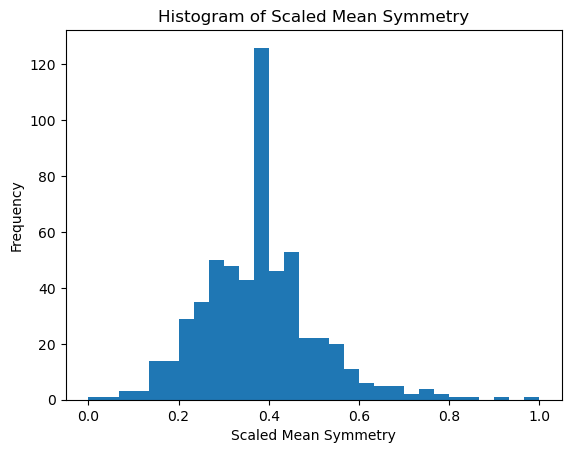

In [8]:
mean_symmetry_values = df.select("mean_symmetry").rdd.flatMap(lambda x: x).collect()

# plots mean_symmetry histogram
plt.hist(mean_symmetry_values, bins=30)
plt.title("Histogram of Scaled Mean Symmetry")
plt.xlabel("Scaled Mean Symmetry")
plt.ylabel("Frequency")
plt.show()

I used Min-Max Scaling to normalize the numeric features. This transformed the data between 0 and 1 values. This reduces the scale of the value and prevents features with larger values from dominating those with smaller values

#### 4. Identify if there are duplicate samples (print their patient IDs) and remove them.


In [9]:
# finds duplicates in patient id 
duplicates = df.groupBy("patient_id").count().filter("count > 1")

duplicates.select("patient_id").show()

df = df.dropDuplicates(["patient_id"])

+----------+
|patient_id|
+----------+
|   8710441|
+----------+



#### 5. Choose any method to remove outliers. Print the number of samples before and after removing outliers as well as the patient IDs of the outliers removed.


In [10]:
num_samples = df.count()
outliers_patient_ids = []

for col_name in numeric_cols:
    q1 = df.approxQuantile(col_name, [0.25], 0.0)[0]
    q3 = df.approxQuantile(col_name, [0.75], 0.0)[0]
    iqr = q3 - q1
    lower_bound = q1 - 2.5 * iqr  # iqr factor here is 2.5 to get a better solution
    upper_bound = q3 + 2.5 * iqr

    # to identify outliers
    outliers_for_feature = df.filter(expr(f"{col_name} < {lower_bound} OR {col_name} > {upper_bound}"))

    # collects outliers patient ids
    outliers_patient_ids += outliers_for_feature.select("patient_id").rdd.flatMap(lambda x: x).collect()

    # to remove outliers
    df = df.filter(expr(f"{col_name} >= {lower_bound} AND {col_name} <= {upper_bound}"))

print(f"Number of samples before removing outliers: {num_samples}")
print(f"Number of samples after removing outliers: {df.count()}")

print("Patient IDs of removed outliers:", outliers_patient_ids)

Number of samples before removing outliers: 568
Number of samples after removing outliers: 413
Patient IDs of removed outliers: ['8810703', '873592', '911296202', '88330202', '8611555', '899987', '86355', '9011971', '9012000', '8910988', '851509', '9012795', '91762702', '926125', '88995002', '884948', '865423', '915143', '878796', '903516', '911157302', '915186', '8610862', '887181', '927241', '8710441', '852631', '858970', '915276', '84348301', '894329', '859711', '8712766', '842302', '90602302', '88299702', '868826', '8610637', '855625', '89263202', '926424', '9011494', '8711803', '855133', '892438', '89812', '875099', '846226', '9113846', '925311', '8811842', '88649001', '881046502', '869104', '914769', '91930402', '84358402', '857392', '88119002', '866203', '883263', '901088', '894618', '926682', '888570', '859575', '857010', '86208', '8712289', '8612399', '849014', '857637', '89742801', '89143602', '873593', '852781', '91485', '852552', '897630', '914062', '911296201', '8610404', 

#### 6. Choose any method to select the most important features and print the name of which features those are. Explain what method you used and why.

In [11]:
from pyspark.ml.feature import VectorAssembler, ChiSqSelector

def select_features(df: DataFrame, num_features: int) -> tuple[DataFrame, ChiSqSelector]:
    # to create seperate header for important features
    selector = ChiSqSelector(numTopFeatures=num_features, featuresCol="features", outputCol="selected_features", labelCol="diagnosis_2")
    
    model = selector.fit(df)
    
    df_feat_sel = model.transform(df)

    return df_feat_sel, model

assembler = VectorAssembler(inputCols=df.columns[2:], outputCol="features")
df_vector = assembler.transform(df)

# adds diagnosis_2 for diagnosis as numeric format
df_vector = df_vector.withColumn("diagnosis_2", F.when(F.col("diagnosis") == 'M', 1).otherwise(0))

num_features = 11
df, model = select_features(df_vector, num_features)

print(f"Selected features indices: {model.selectedFeatures}")

# drops the non-important features from dataset
selected_feature_names = [numeric_cols[i] for i in model.selectedFeatures]

df = df.select("patient_id", "diagnosis", *selected_feature_names)

print(f"Selected features names: {selected_feature_names}")

Selected features indices: [0, 6, 7, 10, 12, 16, 20, 21, 24, 25, 27]
Selected features names: ['mean_radius', 'mean_concavity', 'mean_concave_points', 'se_radius', 'se_perimeter', 'se_concavity', 'worst_radius', 'worst_texture', 'worst_smoothness', 'worst_compactness', 'worst_concave_points']


I used the ChiSqSelector method to do the feature selection as it was working great for categorical data 

#### 7. After all the above, how many samples and features (including patient ID) does the final dataset have?

In [12]:
print(f"Final number of samples: {df.count()}")
print(f"Final number of features: {len(df.columns)}")

Final number of samples: 413
Final number of features: 13


---